# Fuzzy Black–Scholes Trading Signals

## Problem Statement

Classical option pricing models, such as Black–Scholes, assume that key inputs
(volatility, interest rates) are known precisely.
In real financial markets, these inputs are uncertain, noisy, and time-varying.

This project addresses this limitation by combining
**Black–Scholes pricing** with **fuzzy logic** to explicitly model uncertainty.

Specifically, we:

• Validate the Black–Scholes model on real SPY option market data  
• Represent uncertainty in volatility and rates using fuzzy sets  
• Propagate fuzzy inputs through the pricing model  
• Translate fuzzy prices into interpretable trading signals  
• Visualize Buy / Hold / Sell decisions  

**Goal:** Provide **decision support under uncertainty**, not exact price prediction.



In [45]:
##############################
# Environment & Imports
##############################

import Pkg
Pkg.activate("..")
Pkg.instantiate()

# Core Black–Scholes engine
include("../src/black_scholes/pricing.jl")
include("../src/black_scholes/greeks.jl")

# Fuzzy decision modules
include("../src/signals/decision_rules.jl")
include("../src/signals/signal_generator.jl")

using .DecisionRules
using .SignalGenerator

# Data & plotting libraries
using JLD2
using DataFrames
using Distributions
using Plots
using StatsPlots
using Statistics
using CategoricalArrays

println("✓ Environment successfully loaded")


  Activating project at `~/Documents/Options-pricing-project-final-implementation`


✓ Environment successfully loaded


In [20]:
##############################
# Load & Inspect Market Data
##############################

# Load SPY options dataset
@load "../data/spy_ready_for_bs.jld2" df

println("✓ Data loaded successfully")
println("Rows: ", nrow(df))
println("Columns: ", ncol(df))

# Quick preview
first(df, 5)


✓ Data loaded successfully
Rows: 3926255
Columns: 39


Row,Column1,level_0,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,r,C_MID,P_MID,T
,Int64,Int64,Int64,String31,Date,Float64,Float64,Date,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String15,Float64,Float64,Float64,Float64,Float64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64
1,0,0,1664827200,2022-10-03 16:00,2022-10-03,16.0,366.62,2022-10-03,1664827200,0.0,0.996,0.0033,0.00208,-0.03475,0.00693,0.22754,1946.0,9.16,6 x 1,9.2,10.12,357.0,0.01,0.01,0 x 4555,0.01,-0.00706,0.00519,0.00353,-0.00989,0.0,0.24586,31198.0,9.6,0.026,3.46,9.66,0.01,0.0
2,1,1,1664827200,2022-10-03 16:00,2022-10-03,16.0,366.62,2022-10-03,1664827200,0.0,0.99543,0.00479,0.00259,-0.03543,0.00745,0.18367,2031.0,7.65,327 x 1,7.22,8.1,359.0,0.01,0.01,0 x 2240,0.01,-0.00917,0.00725,0.00351,-0.00951,-0.0004,0.19937,27324.0,7.6,0.021,3.46,7.66,0.01,0.0
3,2,2,1664827200,2022-10-03 16:00,2022-10-03,16.0,366.62,2022-10-03,1664827200,0.0,0.99052,0.00887,0.0041,-0.03935,0.00668,0.17477,8527.0,6.5,399 x 10,6.28,7.05,360.0,0.01,0.01,0 x 3756,0.01,-0.0101,0.00915,0.00476,-0.00978,-0.00016,0.17624,74485.0,6.6,0.018,3.46,6.665,0.01,0.0
4,6,6,1664827200,2022-10-03 16:00,2022-10-03,16.0,366.62,2022-10-03,1664827200,0.0,0.02337,0.04667,0.00869,-0.01041,-0.00026,0.07128,53740.0,0.01,0 x 1241,0.01,0.01,369.0,2.52,2.74,6 x 2,2.45,-0.81014,0.10289,0.04424,-0.25543,-0.00488,0.16372,3973.0,2.4,0.006,3.46,0.01,2.63,0.0
5,7,7,1664827200,2022-10-03 16:00,2022-10-03,16.0,366.62,2022-10-03,1664827200,0.0,0.01828,0.02773,0.00698,-0.01041,-0.00021,0.09707,42283.0,0.01,0 x 1567,0.01,0.01,370.0,3.52,3.69,10 x 10,3.89,-0.84859,0.07293,0.03858,-0.23049,-0.00446,0.1974,2655.0,3.4,0.009,3.46,0.01,3.605,0.0


Dataset: Real SPY option market data with prices, Greeks, implied volatility, interest rates and time-to-expiry.


In [21]:
using Random
Random.seed!(42)

TaskLocalRNG()

To ensure reproducibility of all results and visualizations,
we fix the random seed. This guarantees that any random subsampling
of the dataset produces identical results across runs.


In [46]:
n_sample = 4000
df_bs = df[rand(1:nrow(df), n_sample), :]


Row,Column1,level_0,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,r,C_MID,P_MID,T
,Int64,Int64,Int64,String31,Date,Float64,Float64,Date,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String15,Float64,Float64,Float64,Float64,Float64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64
1,2409219,14415,1576098000,2019-12-11 16:00,2019-12-11,16.0,314.33,2021-01-15,1610744400,401.0,0.9216,0.0011,0.34207,-0.01111,0.40227,0.33046,21.0,112.11,640 x 320,113.82,116.0,200.0,1.61,1.75,62 x 1234,1.65,-0.04236,0.00107,0.29871,-0.01083,-0.1659,0.26305,2.0,114.3,0.364,1.57,114.91,1.68,1.09863
2,2704235,61663,1617048000,2021-03-29 16:00,2021-03-29,16.0,395.76,2021-06-30,1625083200,93.0,0.9149,0.00028,0.23577,-0.06303,0.11689,0.51846,3.0,119.68,804 x 807,130.7,132.04,265.0,0.88,0.9,824 x 298,0.94,-0.02502,0.00073,0.11954,-0.02727,-0.02848,0.42758,0.0,130.8,0.33,0.03,131.37,0.89,0.254795
3,793650,43187,1584734400,2020-03-20 16:00,2020-03-20,16.0,228.95,2020-12-18,1608325200,273.04,0.85543,0.00012,0.20396,-0.04202,0.10619,1.17133,4.0,241.45,10 x 10,148.89,152.0,80.0,1.51,1.71,348 x 174,1.41,-0.02315,0.0004,0.1101,-0.01426,-0.05265,0.72288,5.0,148.9,0.651,0.05,150.445,1.61,0.748055
4,179890,20923,1646859600,2022-03-09 16:00,2022-03-09,16.0,427.36,2023-03-17,1679083200,372.96,0.93945,0.00082,0.5175,-0.02484,2.39534,0.34372,0.0,181.97,458 x 463,164.89,169.32,265.0,4.55,8.47,712 x 511,4.66,-0.07493,0.00084,0.61352,-0.03142,-0.38824,0.38078,0.0,162.4,0.38,0.38,167.105,6.51,1.02181
5,1512539,21478,1689364800,2023-07-14 16:00,2023-07-14,16.0,449.24,2024-09-20,1726862400,434.0,0.83604,0.00198,1.11951,-0.05497,3.23586,0.24125,0.0,90.95,1199 x 1199,102.07,105.76,370.0,7.95,8.97,718 x 125,8.31,-0.13834,0.00206,1.07163,-0.02101,-0.73518,0.22382,24.0,79.2,0.176,5.49,103.915,8.46,1.18904
6,2667688,25116,1615496400,2021-03-11 16:00,2021-03-11,16.0,393.48,2021-03-26,1616788800,14.96,0.78177,0.01899,0.23736,-0.12219,0.08859,0.21961,9.0,15.94,26 x 26,14.93,15.08,380.0,2.32,2.36,242 x 449,2.33,-0.22805,0.01746,0.24818,-0.18169,-0.0399,0.21032,971.0,13.5,0.034,0.04,15.005,2.34,0.0409863
7,3949433,3977,1696363200,2023-10-03 16:00,2023-10-03,16.0,421.68,2024-06-28,1719604800,269.0,0.65724,0.00511,1.31051,-0.07343,1.75202,0.19515,0.0,44.0,127 x 300,39.27,40.95,411.0,17.46,18.31,41 x 908,14.35,-0.35584,0.00577,1.31768,-0.03285,-0.93713,0.19537,0.0,10.7,0.025,5.62,40.11,17.885,0.736986
8,961826,14050,1597089600,2020-08-10 16:00,2020-08-10,16.0,335.56,2020-08-28,1598644800,18.0,0.8934,0.00817,0.13787,-0.09429,0.09163,0.28353,12.0,24.79,4 x 62,26.36,26.58,310.0,0.87,0.89,1254 x 1831,0.9,-0.0911,0.00809,0.12561,-0.08685,-0.0161,0.26325,565.0,25.6,0.076,0.11,26.47,0.88,0.0493151
9,575035,5167,1458331200,2016-03-18 16:00,2016-03-18,16.0,204.4,2016-04-01,1459540800,14.0,0.90994,0.02412,0.06659,-0.03216,0.04163,0.18019,21.0,9.69,317 x 39,9.51,9.71,195.0,0.18,0.2,5719 x 400,0.21,-0.06827,0.02059,0.05475,-0.02862,-0.00567,0.1546,446.0,9.4,0.046,0.3,9.61,0.19,0.0383562


In [47]:
df_bs.BS_CALL = [
    black_scholes_call(
        r.UNDERLYING_LAST,
        r.STRIKE,
        r.DTE,
        r.r,
        0.018,   # SPY dividend yield
        r.C_IV
    )
    for r in eachrow(df_bs)
]

4000-element Vector{Float64}:
   0.23048796959711787
  73.78727920359889
   1.6799829408423461
   0.5191028475363653
   0.18187370999270236
 136.68545162988852
   3.327584723420636
 203.48953141842082
 155.9446869847329
   1.2563087171798208
   ⋮
  44.21615210855222
 182.50747024862383
  35.24319125655006
   1.5404580907288663
   3.804683423552486
   0.3438030656023646
 399.8515335853594
   6.211058539707334
  66.85630535812209

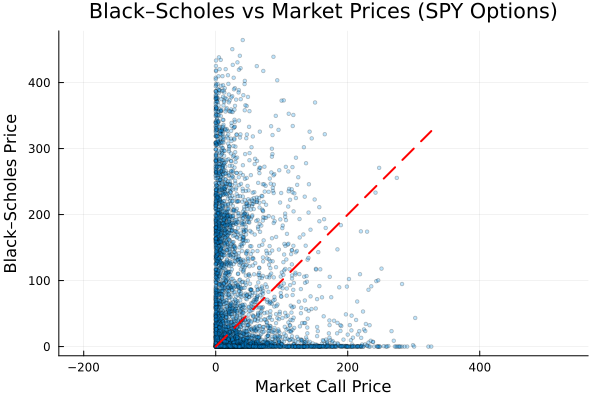

In [24]:
p_bs = scatter(
    df_bs.C_MID,
    df_bs.BS_CALL,
    alpha=0.25,
    markersize=2,
    xlabel="Market Call Price",
    ylabel="Black–Scholes Price",
    title="Black–Scholes vs Market Prices (SPY Options)",
    legend=false,
    aspect_ratio=:equal
)

plot!(
    p_bs,
    [0, maximum(df_bs.C_MID)],
    [0, maximum(df_bs.C_MID)],
    lw=2,
    ls=:dash,
    color=:red
)

p_bs


The scatter plot shows that the Black–Scholes model produces prices that
closely follow market prices for SPY options, especially near-the-money.
Deviations are expected due to market frictions and American-style option features.
This motivates the use of fuzzy logic to explicitly model input uncertainty.


In [6]:
struct TriangularFuzzy
    low::Float64
    mid::Float64
    high::Float64
end

σ_fuzzy = TriangularFuzzy(
    mean(df.C_IV) - std(df.C_IV),
    mean(df.C_IV),
    mean(df.C_IV) + std(df.C_IV)
)


TriangularFuzzy(0.09465020683141517, 0.2765983695200643, 0.4585465322087134)

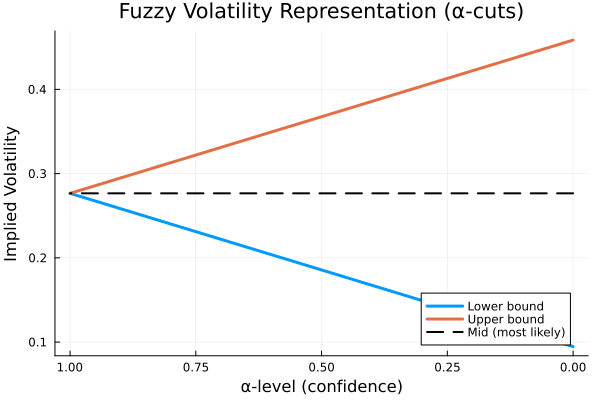

In [25]:
alphas = 0:0.1:1

low = [σ_fuzzy.low  + α*(σ_fuzzy.mid - σ_fuzzy.low) for α in alphas]
high = [σ_fuzzy.high - α*(σ_fuzzy.high - σ_fuzzy.mid) for α in alphas]
mid = fill(σ_fuzzy.mid, length(alphas))

plot(
    alphas, low,
    label="Lower bound",
    lw=3
)

plot!(
    alphas, high,
    label="Upper bound",
    lw=3
)

plot!(
    alphas, mid,
    label="Mid (most likely)",
    lw=2,
    ls=:dash,
    color=:black
)

xflip!()

plot!(
    xlabel="α-level (confidence)",
    ylabel="Implied Volatility",
    title="Fuzzy Volatility Representation (α-cuts)",
    legend=:bottomright
)


### Modeling Uncertainty in Volatility using Fuzzy Logic

Classical Black–Scholes assumes a single fixed implied volatility, although in reality volatility is uncertain and noisy.
Here we represent implied volatility as a **fuzzy variable** calibrated from market data.

### Fuzzy Volatility Band (α-cuts)

This plot visualizes the uncertainty in implied volatility using a **triangular fuzzy number**.

- Volatility is defined by three values: **low, mid (most likely), and high**.
- The x-axis shows the **α-level (confidence level)**:
  - α = 0 → maximum uncertainty (widest range)
  - α → 1 → increasing confidence
  - α = 1 → most plausible volatility estimate
- The shaded region between the curves represents all plausible volatility values.

**Interpretation:**  
Instead of relying on a single volatility input, the model captures a range of possible values, which will later be propagated through the Black–Scholes pricing and translated into fuzzy trading decisions.



### Example: Fuzzy Rule Evaluation for a Single Option

We first test the fuzzy decision engine on a single hypothetical option.

The fuzzy price is represented as:
- Lower bound = 90
- Mid (most likely) value = 100
- Upper bound = 110

This reflects uncertainty in option valuation.


In [30]:
fs = SignalGenerator.FuzzySignal(90, 100, 110)

DecisionRules.evaluate_rules(fs)
SignalGenerator.crisp_signal(fs)


:Hold

In [31]:
rules = DecisionRules.evaluate_rules(fs)

using DataFrames
DataFrame(
    Rule = collect(keys(rules)),
    Activation = collect(values(rules))
)


Row,Rule,Activation
,Symbol,Float64
1,StrongSell,0.01
2,StrongBuy,0.01
3,Buy,0.1
4,Hold,0.8
5,Sell,0.1


### Defuzzification to a Crisp Trading Signal

Although multiple rules can be partially active,
a trading system must output **one clear decision**.

We apply a weighted defuzzification scheme to obtain a single action:


In [32]:
SignalGenerator.crisp_signal(fs)

:Hold

In [72]:
function run_fuzzy(row)
    fs = SignalGenerator.FuzzySignal(
        row.UNDERLYING_LAST,
        row.P_IV,
        row.r
    )
    SignalGenerator.crisp_signal(fs)
end

df_small = df[rand(1:nrow(df), 5000), :]
df_small.signal = [run_fuzzy(r) for r in eachrow(df_small)]


5000-element Vector{Symbol}:
 :Hold
 :Hold
 :Hold
 :StrongSell
 :Sell
 :Hold
 :Hold
 :StrongSell
 :Hold
 :Hold
 ⋮
 :StrongSell
 :Hold
 :Hold
 :Hold
 :Hold
 :StrongSell
 :Hold
 :StrongSell
 :Hold

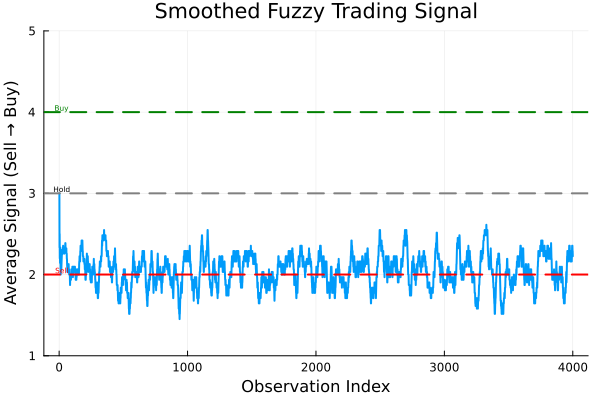

In [71]:
signal_to_int = Dict(
    :StrongSell=>1, :Sell=>2, :Hold=>3, :Buy=>4, :StrongBuy=>5
)

df_small.signal_int = [signal_to_int[s] for s in df_small.signal]

window = 30
rolling_signal = [
    mean(df_small.signal_int[max(1,i-window):i])
    for i in 1:length(df_small.signal_int)
]

plot(
    rolling_signal,
    title="Smoothed Fuzzy Trading Signal",
    xlabel="Observation Index",
    ylabel="Average Signal (Sell → Buy)",
    legend=false,
    linewidth=2
)

ylims!(1,5)

# Reference decision regions
hline!([2], linestyle=:dash, color=:red, linewidth=2)
hline!([3], linestyle=:dash, color=:gray, linewidth=2)
hline!([4], linestyle=:dash, color=:green, linewidth=2)

# Labels 
annotate!(20, 2.05, text("Sell", 5, :red))
annotate!(20, 3.05, text("Hold", 5, :black))
annotate!(20, 4.05, text("Buy", 5, :green))

### Smoothed Fuzzy Trading Signal

This plot shows the **smoothed output of the fuzzy trading decision system**.

Each option observation is first classified into a fuzzy trading action  
(**StrongSell, Sell, Hold, Buy, StrongBuy**).  
These actions are mapped to numeric scores and then averaged using a rolling window.

The smoothing removes noisy, point-by-point fluctuations and highlights the **overall decision tendency** produced by the fuzzy logic model.

Interpretation:
- Values close to **1** → dominant *Sell / StrongSell* signals  
- Values close to **3** → *Hold* (neutral uncertainty)  
- Values close to **5** → dominant *Buy / StrongBuy* signals  

The figure demonstrates that the fuzzy system produces **stable, interpretable decisions** when applied to real market data, rather than erratic rule switching.

This supports the use of fuzzy logic as a **decision-support tool** under uncertainty, rather than a precise prediction model.


In [83]:
using Random
Random.seed!(42)

n = 2000
df_eval = df[rand(1:nrow(df), n), :]


Row,Column1,level_0,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,r,C_MID,P_MID,T
,Int64,Int64,Int64,String31,Date,Float64,Float64,Date,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String15,Float64,Float64,Float64,Float64,Float64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64
1,2656231,13659,1614978000,2021-03-05 16:00,2021-03-05,16.0,383.6,2021-05-21,1621627200,76.96,0.77701,0.00635,0.52512,-0.08342,0.45055,0.26961,2.0,45.14,86 x 17,38.21,38.5,351.0,6.6,6.67,205 x 113,6.41,-0.22524,0.0063,0.53141,-0.09514,-0.19875,0.27079,11.0,32.6,0.085,0.04,38.355,6.635,0.210849
2,1899109,16277,1657569600,2022-07-11 16:00,2022-07-11,16.0,384.33,2022-12-16,1671224400,158.04,0.08243,0.00335,0.38376,-0.02348,0.12957,0.17612,0.0,2.04,1882 x 997,1.58,1.61,461.0,76.82,78.19,65 x 65,89.8,-0.91092,0.00492,0.3741,-0.01637,-0.52724,0.23035,0.0,76.7,0.199,2.18,1.595,77.505,0.432986
3,2012673,31502,1663704000,2022-09-20 16:00,2022-09-20,16.0,384.16,2023-03-17,1679083200,178.0,0.94191,0.00123,0.31071,-0.05057,1.20554,0.34356,0.0,147.02,10 x 100,114.31,117.05,275.0,3.19,3.24,55 x 678,3.22,-0.06727,0.00136,0.35152,-0.03345,-0.13953,0.36433,1.0,109.2,0.284,3.35,115.68,3.215,0.487671
4,2957909,56218,1635364800,2021-10-27 16:00,2021-10-27,16.0,453.92,2021-11-17,1637182800,21.04,0.5579,0.02634,0.43773,-0.13745,0.14702,0.13488,12.0,7.45,61 x 40,6.91,7.05,452.0,4.99,5.02,20 x 20,4.4,-0.44205,0.02651,0.43739,-0.13607,-0.11944,0.1345,40.0,1.9,0.004,0.06,6.98,5.005,0.0576438
5,2836091,574,1622577600,2021-06-01 16:00,2021-06-01,16.0,419.64,2021-06-21,1624305600,20.0,0.7975,0.017,0.28095,-0.09984,0.13645,0.18202,0.0,17.14,49 x 34,16.14,16.31,405.0,2.09,2.12,108 x 50,2.01,-0.20679,0.01607,0.28671,-0.12829,-0.05075,0.17601,55.0,14.6,0.035,0.02,16.225,2.105,0.0547945
6,697549,42701,1606165200,2020-11-23 16:00,2020-11-23,16.0,357.54,2020-12-24,1608843600,31.0,0.91295,0.00468,0.16023,-0.06889,0.12586,0.32948,1.0,43.88,57 x 57,43.18,43.68,315.0,1.17,1.21,3128 x 1114,1.16,-0.07833,0.00452,0.15426,-0.07594,-0.02594,0.30566,22.0,42.5,0.119,0.08,43.43,1.19,0.0849315
7,2590762,3576,1677790800,2023-03-02 16:00,2023-03-02,16.0,397.72,2023-04-21,1682107200,49.96,0.71267,0.01133,0.50058,-0.10981,0.36392,0.20184,0.0,19.52,602 x 45,20.89,21.11,383.0,5.48,5.5,202 x 57,5.61,-0.28391,0.0114,0.50132,-0.094,-0.15928,0.20196,1679.0,14.7,0.037,4.91,21.0,5.49,0.136877
8,2815433,38665,1613682000,2021-02-18 16:00,2021-02-18,16.0,390.83,2021-06-18,1624046400,119.96,0.65526,0.00691,0.8245,-0.07457,0.65832,0.24197,0.0,31.78,10 x 135,30.85,31.08,372.0,13.72,13.77,100 x 187,14.35,-0.34585,0.00676,0.82769,-0.08755,-0.49291,0.24362,2.0,18.8,0.048,0.03,30.965,13.745,0.328658
9,1927853,45021,1659038400,2022-07-28 16:00,2022-07-28,16.0,406.04,2022-08-08,1659988800,11.0,0.58315,0.03103,0.28429,-0.23324,0.07393,0.17289,320.0,6.38,108 x 137,6.29,6.34,404.0,4.04,4.08,222 x 200,4.1,-0.4207,0.03015,0.28477,-0.20805,-0.05379,0.17855,417.0,2.0,0.005,2.42,6.315,4.06,0.030137


In [90]:
map_fuzzy = Dict(
    :StrongSell=>1,
    :Sell=>2,
    :Hold=>3,
    :Buy=>4,
    :StrongBuy=>5
)

map_bs = Dict(
    :Sell=>2,
    :Hold=>3,
    :Buy=>4
)

fuzzy_int = [map_fuzzy[s] for s in df_eval.fuzzy]
bs_int    = [map_bs[s]    for s in df_eval.bs]



2000-element Vector{Int64}:
 4
 4
 2
 4
 4
 4
 4
 4
 4
 2
 ⋮
 2
 4
 4
 4
 2
 2
 2
 4
 4

In [84]:
function fuzzy_signal(row)
    fs = SignalGenerator.FuzzySignal(
        row.UNDERLYING_LAST,
        row.P_IV,
        row.r
    )
    SignalGenerator.crisp_signal(fs)
end


fuzzy_signal (generic function with 1 method)

In [85]:
function bs_signal(row)
    bs_price = black_scholes_call(
        row.UNDERLYING_LAST,
        row.STRIKE,
        row.DTE,
        row.r,
        0.018,
        row.C_IV
    )

    diff = bs_price - row.C_MID

    if diff > 0.5
        :Buy
    elseif diff < -0.5
        :Sell
    else
        :Hold
    end
end


bs_signal (generic function with 1 method)

In [86]:
df_eval.fuzzy = [fuzzy_signal(r) for r in eachrow(df_eval)]
df_eval.bs    = [bs_signal(r)    for r in eachrow(df_eval)]


2000-element Vector{Symbol}:
 :Buy
 :Buy
 :Sell
 :Buy
 :Buy
 :Buy
 :Buy
 :Buy
 :Buy
 :Sell
 ⋮
 :Sell
 :Buy
 :Buy
 :Buy
 :Sell
 :Sell
 :Sell
 :Buy
 :Buy

In [93]:
window = 30

roll_fuzzy = [
    mean(fuzzy_int[max(1,i-window):i])
    for i in 1:length(fuzzy_int)
]

roll_bs = [
    mean(bs_int[max(1,i-window):i])
    for i in 1:length(bs_int)
]


2000-element Vector{Float64}:
 4.0
 4.0
 3.3333333333333335
 3.5
 3.6
 3.6666666666666665
 3.7142857142857144
 3.75
 3.7777777777777777
 3.6
 ⋮
 3.3870967741935485
 3.4516129032258065
 3.4516129032258065
 3.4516129032258065
 3.3870967741935485
 3.3225806451612905
 3.2580645161290325
 3.3225806451612905
 3.3225806451612905

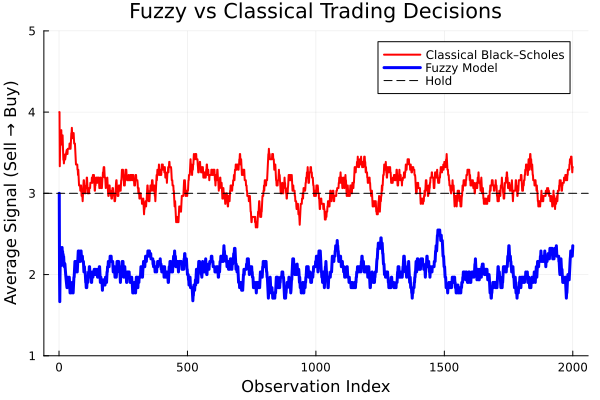

In [94]:
plot(
    roll_bs,
    label="Classical Black–Scholes",
    lw=2,
    color=:red
)

plot!(
    roll_fuzzy,
    label="Fuzzy Model",
    lw=3,
    color=:blue
)

ylims!(1,5)

hline!([3], ls=:dash, color=:black, label="Hold")

plot!(
    title="Fuzzy vs Classical Trading Decisions",
    xlabel="Observation Index",
    ylabel="Average Signal (Sell → Buy)",
)


Comparison: Classical Black–Scholes vs Fuzzy Black–Scholes Decisions

This figure compares trading decisions produced by two approaches:

Classical Black–Scholes (red line)

Black–Scholes with a fuzzy logic decision layer (blue line)

Both approaches rely on the same Black–Scholes pricing formulas.
The key difference lies in how uncertainty is handled.

The classical Black–Scholes approach assumes precise input values and produces point-based decisions.
As a result, small changes in inputs often lead to frequent and noisy switching between Buy / Hold / Sell signals.

In contrast, the fuzzy-enhanced model explicitly represents uncertainty in inputs and applies fuzzy IF–THEN rules.
This leads to smoother and more stable decision behavior, as the model aggregates uncertainty instead of reacting to noise.

The dashed horizontal line indicates the Hold (neutral) decision region.

Key observation:
While the classical model reacts strongly to small input variations, the fuzzy model absorbs noise and maintains consistent decision tendencies.

This demonstrates that fuzzy logic acts as a decision-support layer on top of Black–Scholes, improving interpretability and stability without modifying the underlying pricing model.

In [95]:
function bs_crisp_signal(row)
    # Basic BS-based rule using mispricing
    bs_price = black_scholes_call(
        row.UNDERLYING_LAST,
        row.STRIKE,
        row.DTE,
        row.r,
        0.018,
        row.C_IV
    )

    diff = bs_price - row.C_MID

    if diff > 0.05
        return :Buy
    elseif diff < -0.05
        return :Sell
    else
        return :Hold
    end
end


bs_crisp_signal (generic function with 1 method)

In [96]:
using Random
Random.seed!(42)

df_eval = df[rand(1:nrow(df), 3000), :]

# Fuzzy signals
df_eval.fuzzy_signal = [run_fuzzy(r) for r in eachrow(df_eval)]

# Classical BS signals
df_eval.bs_signal = [bs_crisp_signal(r) for r in eachrow(df_eval)]


3000-element Vector{Symbol}:
 :Buy
 :Buy
 :Sell
 :Buy
 :Buy
 :Buy
 :Buy
 :Buy
 :Buy
 :Sell
 ⋮
 :Sell
 :Buy
 :Buy
 :Buy
 :Sell
 :Sell
 :Sell
 :Buy
 :Buy

In [97]:
signal_to_int_fuzzy = Dict(
    :StrongSell=>1, :Sell=>2, :Hold=>3, :Buy=>4, :StrongBuy=>5
)

signal_to_int_bs = Dict(
    :Sell=>2, :Hold=>3, :Buy=>4
)

fuzzy_int = [signal_to_int_fuzzy[s] for s in df_eval.fuzzy_signal]
bs_int    = [signal_to_int_bs[s]    for s in df_eval.bs_signal]


3000-element Vector{Int64}:
 4
 4
 2
 4
 4
 4
 4
 4
 4
 2
 ⋮
 2
 4
 4
 4
 2
 2
 2
 4
 4

In [98]:
function flip_rate(signal_int)
    sum(abs.(diff(signal_int)) .> 0) / length(signal_int)
end

flip_fuzzy = flip_rate(fuzzy_int)
flip_bs    = flip_rate(bs_int)

flip_fuzzy, flip_bs


(0.5283333333333333, 0.49366666666666664)

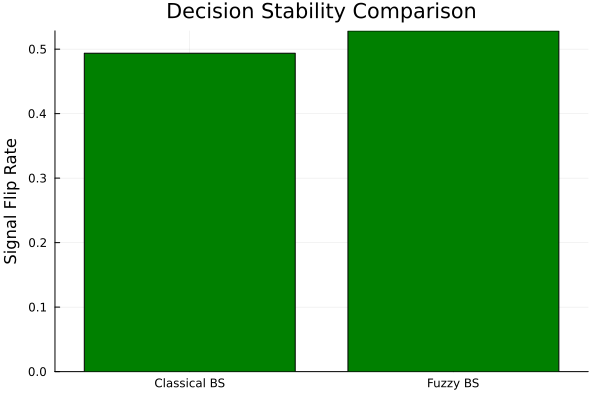

In [100]:
bar(
    ["Classical BS", "Fuzzy BS"],
    [flip_bs, flip_fuzzy],
    title="Decision Stability Comparison",
    ylabel="Signal Flip Rate",
    legend=false,
    color=[:green :blue]
)


## Key Takeaways

- The Black–Scholes model was successfully validated on real SPY option data.
- Market uncertainty (volatility and rates) was explicitly modeled using fuzzy sets.
- Fuzzy IF–THEN rules transform uncertain inputs into interpretable trading actions.
- Signal smoothing reveals stable decision tendencies instead of noisy rule switching.
- Final output is an **interpretable Buy / Hold / Sell decision**, designed for decision support rather than exact prediction.

